In [1]:
import sys
sys.path.insert(0, "../../pinn/")

import numpy as np

from pinn import *
from pinnutils import *

import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

# raissi plots
from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device("cpu")

def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

xb = np.linspace(0,1,100)
yb = np.linspace(0,1,100)

cuda


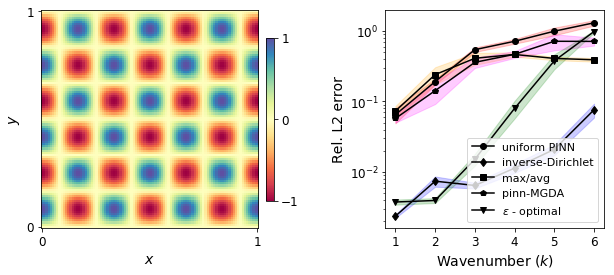

In [13]:
errs = []
for seed in range(1,6):
    _errs = []
    for method in [4,0,2,3,5]:
        __errs = []
        for scale in range(1,7):
            omega = scale*np.pi
            xx,yy = np.meshgrid(x,y)
            u_sol = poisson_equation(xx,yy,omega)

            X = np.vstack([xx.ravel(), yy.ravel()]).T

            yt = np.zeros((u_sol.size, 1), dtype=np.float)
            for i,_x in enumerate(u_sol.real.T):
                yt[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)
                
            app = "_eps1e5" + "_lr1e2"
            net = torch.load('./models/poisson_ada_meth' + str(method) + '_scale' + str(scale) + '_5L' + '_N2500' + '_ep' + str(30000)  + '_' + "tanh" + "_seed"+ str(seed) + app + '.pth',
                             map_location=device)
            
            Xin = torch.tensor(X, dtype=torch.float32)
            out = net(Xin).cpu().data.numpy()
            
            err = np.linalg.norm(out-u_sol.reshape(100*100,1))/np.linalg.norm(u_sol.reshape(100*100,1))
            __errs.append(err)
        _errs.append(__errs)
    errs.append(_errs)
    
errs = np.array(errs)

mm = np.mean(errs, 0)
ss = np.std(errs, 0)


mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12

colors = ["red", "blue", "orange", "magenta", "green"]
labels = [r"uniform PINN", "inverse-Dirichlet", "max/avg", "pinn-MGDA", r"$\epsilon$ - optimal"]
markers = ["o", "d", "s", "p", "v"]

omega = 6*np.pi
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

fig,axs = plt.subplots(1,2,figsize=(14,4), gridspec_kw={'width_ratios': [.5,.28]})

# ground truth
im = axs[0].imshow(u_sol, cmap="Spectral", vmin=-1, vmax=1, origin="bottom")
fig.colorbar(im, ax=axs[0], ticks=[-1,0,1], pad=0.02, shrink=0.75)
axs[0].set_xlabel(r"$x$", fontsize=14)
axs[0].set_ylabel(r"$y$", fontsize=14)
axs[0].set_xticks([0,99])
axs[0].set_yticks([0,99])
axs[0].set_yticklabels(["0", "1"])
axs[0].set_xticklabels(["0", "1"])

# prediction errors
for i in range(5):
    axs[1].plot(range(1,7), mm[i,:], marker=markers[i], color="black", label=labels[i])
    axs[1].fill_between(range(1,7), mm[i,:]-(.5*ss[i,:]), mm[i,:]+(ss[i,:]*.5), color=colors[i], alpha=0.2)
    
axs[1].set_xlabel(r"Wavenumber $(k)$", fontsize=14)
axs[1].set_ylabel("Rel. L2 error", fontsize=14)
axs[1].legend(fontsize=11)
axs[1].set_yscale("log")

plt.gcf().set_size_inches(12,4)
plt.savefig("poisson_erros_adagrad_1e5_lr1e2.eps")